In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import scanpy.external as sce
import scvi
from scvi.model import CondSCVI, DestVI
import torch
from scvi.external import RNAStereoscope, SpatialStereoscope
import matplotlib.pyplot as plt

In [6]:
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, format="pdf")
sc.settings.verbosity = 3

-----
anndata     0.7.5
scanpy      1.8.1
sinfo       0.3.1
-----
OpenSSL             20.0.1
PIL                 8.1.1
absl                NA
anndata             0.7.5
anyio               NA
argon2              20.1.0
asciitree           NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
boto3               1.20.24
botocore            1.23.24
brotli              NA
cairo               1.20.0
certifi             2021.10.08
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.3.0
colorama            0.4.4
cryptography        3.4.4
cycler              0.10.0
cython_runtime      NA
dask                2021.02.0
dateutil            2.8.1
decorator           4.4.2
deprecate           0.3.0
fasteners           NA
fsspec              2021.05.0
future_fstrings     NA
google              NA
h5py                2.10.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipyth

In [12]:
samples = ['Mock-Heart-D4PI', 'T1L-Heart-D4PI', 'Mock-Heart-D7PI', 'T1L-Heart-D7PI']

In [15]:
heart_infection_sc_no_viral_genes = sc.read_h5ad('./../../../pyobjs_github/heart_infection_sc_raw_counts.h5ad')
heart_infection_sc_no_viral_genes.layers["counts"] = heart_infection_sc_no_viral_genes.X.copy()
heart_infection_sc_no_viral_genes.obs = sc.read_h5ad("./../../../pyobjs_github/heart_infection_sc.h5ad").obs
heart_infection_sc_no_viral_genes

AnnData object with n_obs × n_vars = 31684 × 22757
    obs: 'sample', 'T1LReoS1', 'T1LReoS2', 'T1LReoS3', 'T1LReoS4', 'T1LReoM1', 'T1LReoM2', 'T1LReoM3', 'T1LReoL1', 'T1LReoL2', 'T1LReoL3', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_viral', 'pct_viral', 'stage', 'state', 'condition', 'n_genes', 'S_score', 'G2M_score', 'phase', 'umap_density_condition', 'leiden_0.5', 'leiden_0.3', 'leiden_0.1', 'celltypes_leiden_0.3', 'celltypes_leiden_0.5', 'celltype_groups'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'condition_colors'
    layers: 'counts'

In [16]:
sc.pp.normalize_total(heart_infection_sc_no_viral_genes, target_sum=10e4)
sc.pp.log1p(heart_infection_sc_no_viral_genes)
sc.pp.highly_variable_genes(heart_infection_sc_no_viral_genes, max_mean=3.0, min_disp=0.5)
heart_infection_sc_no_viral_genes.raw = heart_infection_sc_no_viral_genes
heart_infection_sc_no_viral_genes = heart_infection_sc_no_viral_genes[:, heart_infection_sc_no_viral_genes.var.highly_variable]
print(heart_infection_sc_no_viral_genes.shape)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/home/mm2937/miniconda3/envs/python385/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(31684, 3886)


In [21]:
T1L_heart_D7PI_visium = sc.read_visium(path="./../../../spatialData/T1L-Heart-D7PI/outs/")
T1L_heart_D7PI_visium.var_names_make_unique()
print(T1L_heart_D7PI_visium)

reoviral_genes = [name for name in T1L_heart_D7PI_visium.var_names if name.startswith('Reo')]
print(reoviral_genes)
viral_expression = T1L_heart_D7PI_visium[:,reoviral_genes].to_df()
viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
reoviral_genes_indicator = np.in1d(T1L_heart_D7PI_visium.var_names, reoviral_genes)
T1L_heart_D7PI_visium_no_viral_genes = T1L_heart_D7PI_visium[:, ~reoviral_genes_indicator]
T1L_heart_D7PI_visium_no_viral_genes.var_names = [name.split("_")[1] for name in T1L_heart_D7PI_visium_no_viral_genes.var_names]
T1L_heart_D7PI_visium_no_viral_genes.obs.join(viral_expression.astype(int))
print(T1L_heart_D7PI_visium_no_viral_genes.shape)

T1L_heart_D7PI_visium_no_viral_genes.obs_names_make_unique()
T1L_heart_D7PI_visium_no_viral_genes.var_names_make_unique()

sc.pp.filter_cells(T1L_heart_D7PI_visium_no_viral_genes, min_counts=1)
sc.pp.filter_genes(T1L_heart_D7PI_visium_no_viral_genes, min_cells=1)

T1L_heart_D7PI_visium_no_viral_genes.var['mt'] = T1L_heart_D7PI_visium_no_viral_genes.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(T1L_heart_D7PI_visium_no_viral_genes, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

T1L_heart_D7PI_visium_no_viral_genes.layers["counts"] = T1L_heart_D7PI_visium_no_viral_genes.X.copy()

sc.pp.normalize_total(T1L_heart_D7PI_visium_no_viral_genes, target_sum=10e4)
sc.pp.log1p(T1L_heart_D7PI_visium_no_viral_genes)

T1L_heart_D7PI_visium_no_viral_genes.raw = T1L_heart_D7PI_visium_no_viral_genes    

reading ../../../spatialData/T1L-Heart-D7PI/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2278 × 54848
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'
['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(2278, 54838)
filtered out 36885 genes that are detected in less than 1 cells
normalizing counts per cell
    finished (0:00:00)


In [22]:
intersect = np.intersect1d(heart_infection_sc_no_viral_genes.var_names, T1L_heart_D7PI_visium_no_viral_genes.var_names)
print(len(intersect))
T1L_heart_D7PI_visium_no_viral_genes = T1L_heart_D7PI_visium_no_viral_genes[:, intersect].copy()
heart_infection_sc_no_viral_genes = heart_infection_sc_no_viral_genes[:, intersect].copy()

2482


In [23]:
scvi.data.setup_anndata(heart_infection_sc_no_viral_genes, layer="counts", labels_key="celltypes_leiden_0.5")

INFO     No batch_key inputted, assuming all cells are same batch                            


No batch_key inputted, assuming all cells are same batch


INFO     Using labels from adata.obs["celltypes_leiden_0.5"]                                 


Using labels from adata.obs["celltypes_leiden_0.5"]


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch


INFO     Successfully registered anndata object containing 31684 cells, 2482 vars, 1 batches,
         20 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


Successfully registered anndata object containing 31684 cells, 2482 vars, 1 batches, 20 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.


In [25]:
# sc_model = CondSCVI(heart_infection_sc_no_viral_genes)
# sc_model = CondSCVI(heart_infection_sc_no_viral_genes, weight_obs=True)
# sc_model.train(max_epochs=250)
# sc_model.history["elbo_train"].plot()
train = False
if train:
    sc_model = RNAStereoscope(heart_infection_sc_no_viral_genes)
    sc_model.train(max_epochs = 200)
    sc_model.history["elbo_train"][10:].plot()
    sc_model.save("scmodel", overwrite=True)
else:
    sc_model = RNAStereoscope.load("scmodel", heart_infection_sc_no_viral_genes)
    print("Loaded RNA model from file!")

INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     


Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']


INFO     Successfully registered anndata object containing 31684 cells, 2482 vars, 1 batches,
         20 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        


Successfully registered anndata object containing 31684 cells, 2482 vars, 1 batches, 20 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


Loaded RNA model from file!


In [26]:
scvi.data.setup_anndata(T1L_heart_D7PI_visium_no_viral_genes, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            


No batch_key inputted, assuming all cells are same batch


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch
/home/mm2937/miniconda3/envs/python385/lib/python3.8/site-packages/scvi/data/_utils.py:22: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  warnings.warn(


INFO     Successfully registered anndata object containing 2278 cells, 2482 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 2278 cells, 2482 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.


In [28]:
# st_model = DestVI.from_rna_model(T1L_heart_D7PI_visium_no_viral_genes, sc_model)
# st_model.train(max_epochs=2000)
# st_model.history["elbo_train"].plot()
train=False
if train:
    spatial_model = SpatialStereoscope.from_rna_model(T1L_heart_D7PI_visium_no_viral_genes, sc_model)
    spatial_model.train(max_epochs = 1500)
    spatial_model.history["elbo_train"][10:].plot()
    spatial_model.save("stmodel", overwrite = True)
else:
    spatial_model = SpatialStereoscope.load("stmodel", T1L_heart_D7PI_visium_no_viral_genes)
    print("Loaded Spatial model from file!")

INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch


INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels',     
         'ind_x']                                                                            


Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels', 'ind_x']


INFO     Successfully registered anndata object containing 2278 cells, 2482 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 2278 cells, 2482 vars, 1 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


Loaded Spatial model from file!


In [29]:
T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"] = spatial_model.get_proportions().drop("", axis=1)

In [30]:
ct_list = list(T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].columns)
print(ct_list)
for ct in ct_list:
    data = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"][ct].values
    T1L_heart_D7PI_visium_no_viral_genes.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))
    
T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred"] = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"][ct_list].max(axis=1)
T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"] = T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"][ct_list].idxmax(axis=1)

['B cells', 'Cardiomyocytes', 'Ccl2+ fibroblasts', 'Cxcl9-high inflamed\n endothelial cells', 'Dendritic cells', 'Endocardial cells', 'Endothelial cells', 'Erythroblasts', 'Fibroblasts', 'Inflamed endothelial cells', 'Macrophages', 'Mesenchymal endothelial cells', 'NK cells', 'Neutrophils', 'Pericardial cells', 'Pericytes', 'Schwann cells', 'Smooth muscle cells', 'T cells']


In [31]:
sc_cluster_order = ["Endocardial cells",
                                "Pericardial cells",
                                "Schwann cells",
                                "Ccl2+ fibroblasts",
                                "Fibroblasts", 
                                "Neutrophils",
                                "Dendritic cells",
                                "Macrophages",
                                "B cells",
                                "NK cells",
                                "T cells",
                                "Cxcl9-high inflamed\n endothelial cells",
                                "Endothelial cells",
                                "Inflamed endothelial cells",
                                "Smooth muscle cells",
                                "Mesenchymal endothelial cells",
                                "Pericytes", 
                                "Cardiomyocytes",
                                "Erythroblasts"]
T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"] = T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"].astype("category")
T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"].cat.reorder_categories(
    new_categories= sc_cluster_order, inplace = True)

<ipython-input-31-3044c1a69fcb>:21: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  T1L_heart_D7PI_visium_no_viral_genes.obs["max_pred_celltype"].cat.reorder_categories(


... storing 'feature_types' as categorical
... storing 'genome' as categorical


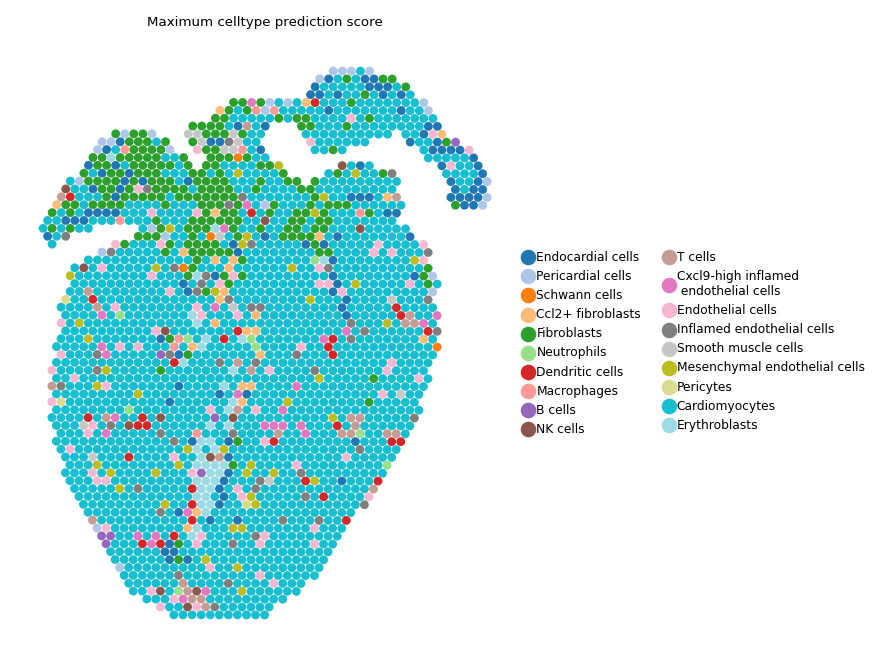

In [32]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(5, 5), transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(
        T1L_heart_D7PI_visium_no_viral_genes,
        img_key="hires",
        color=["max_pred_celltype"],
        show=True, 
        frameon=False,
        palette="tab20",
        title="Maximum celltype prediction score",
        size=1.5, scale_factor=1.0)

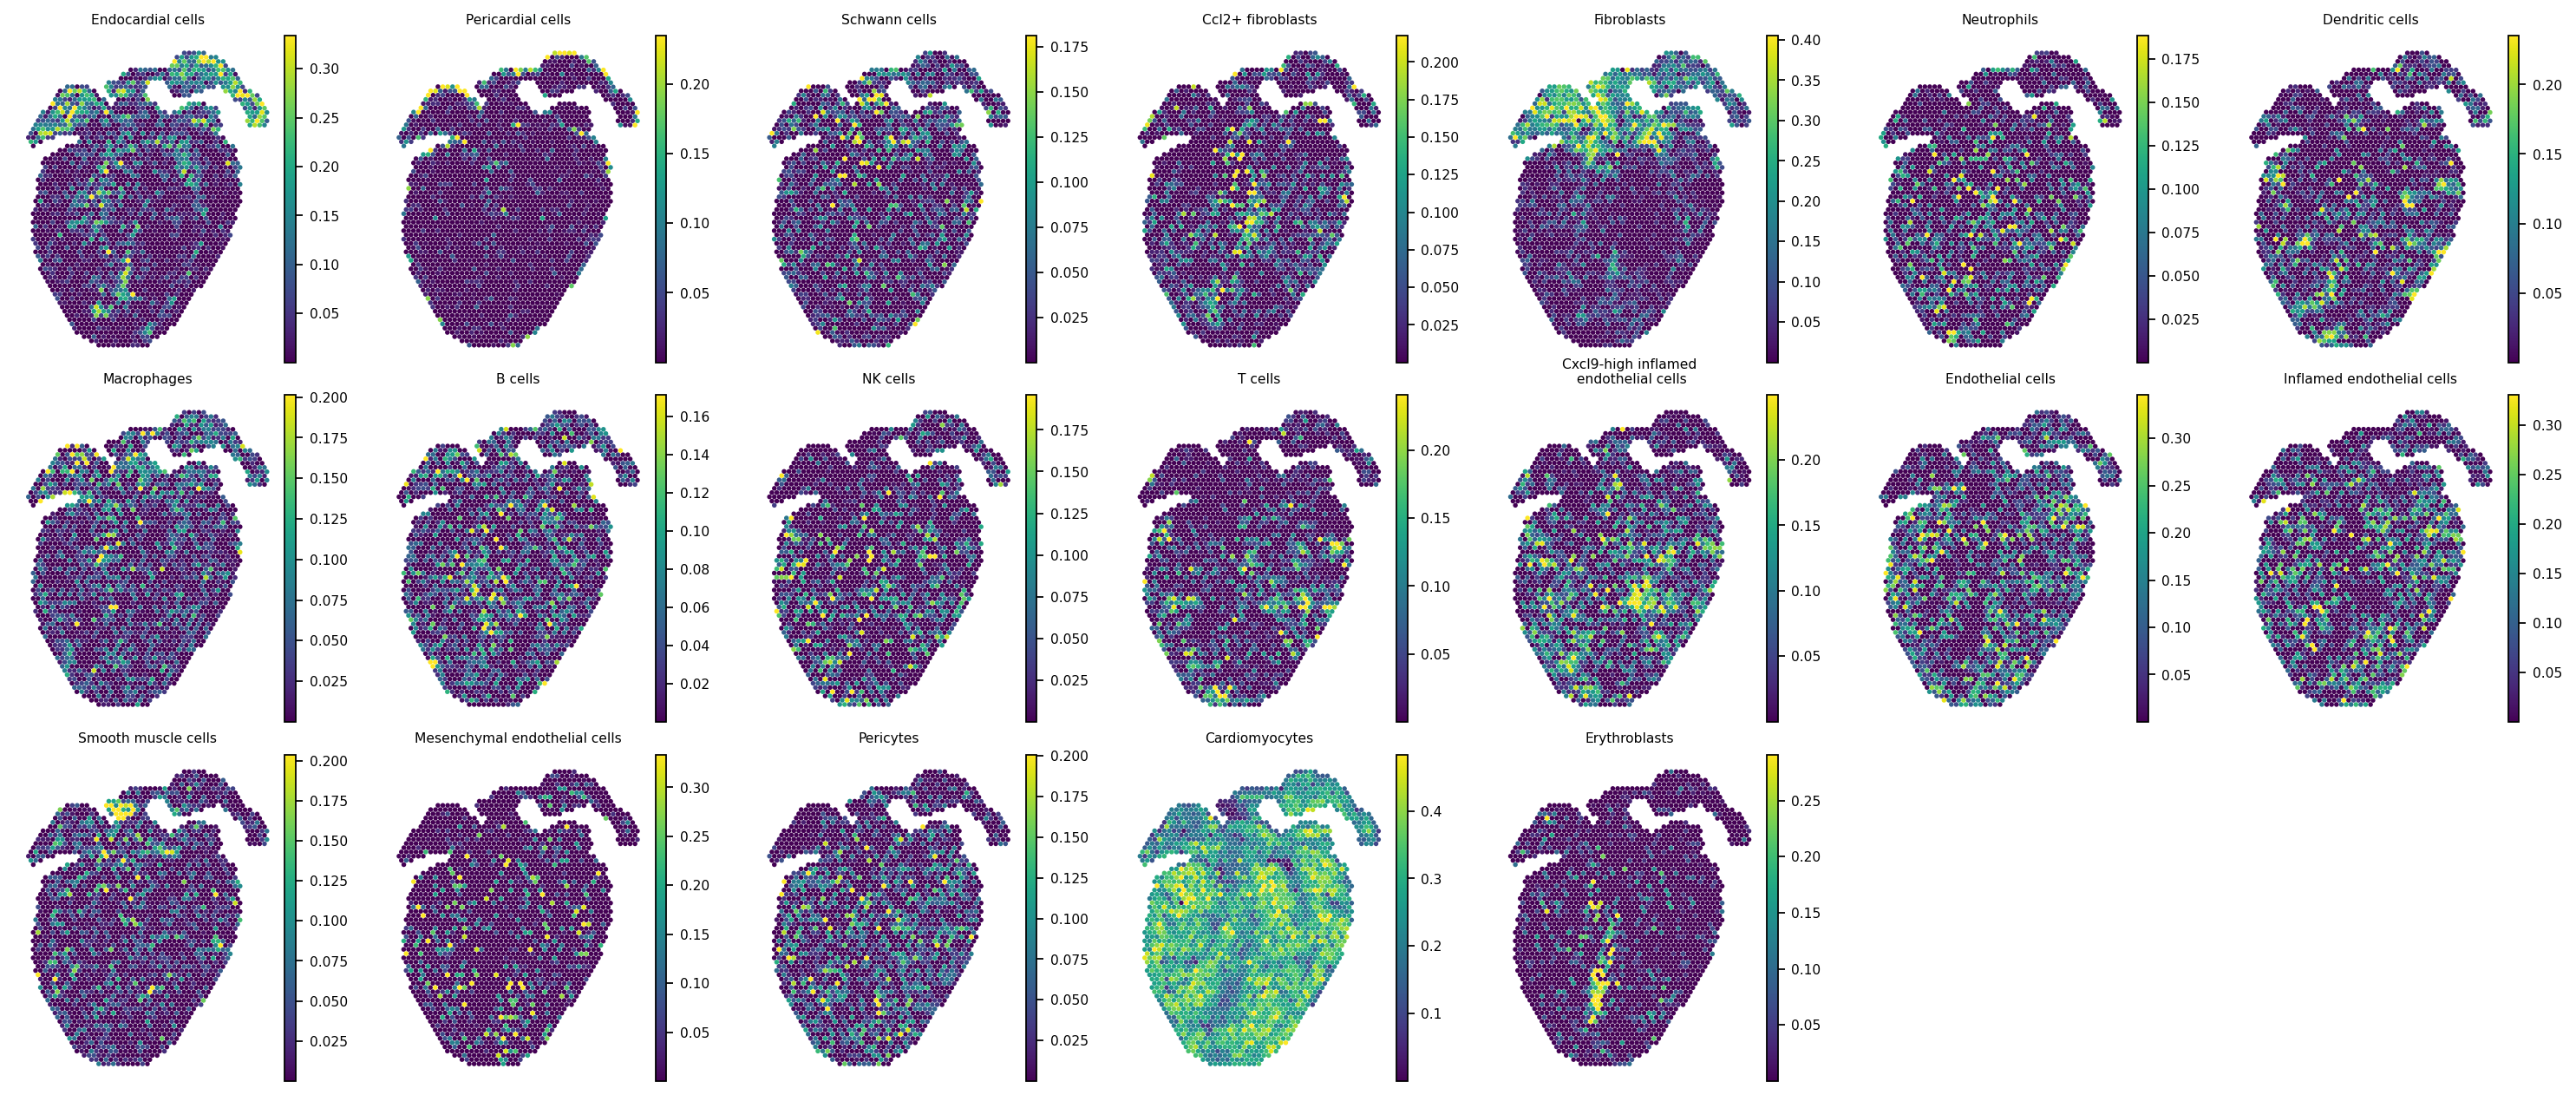

In [38]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=7, figsize=(3.0,3.0), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=sc_cluster_order, ncols=7, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1)

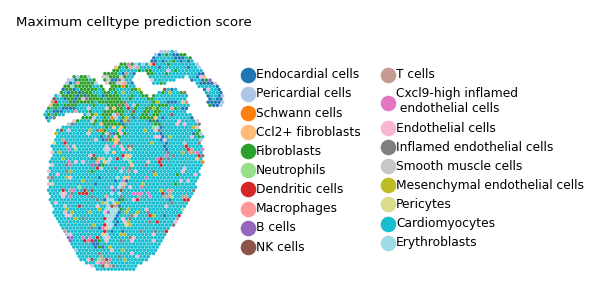

In [60]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(2, 2), transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(
        T1L_heart_D7PI_visium_no_viral_genes,
        img_key="hires",
        color=["max_pred_celltype"],
        show=True, 
        frameon=False,
        palette="tab20",
        title="Maximum celltype prediction score",
        size=1.5, scale_factor=1.0, save="day7_spatial_deconv.pdf")

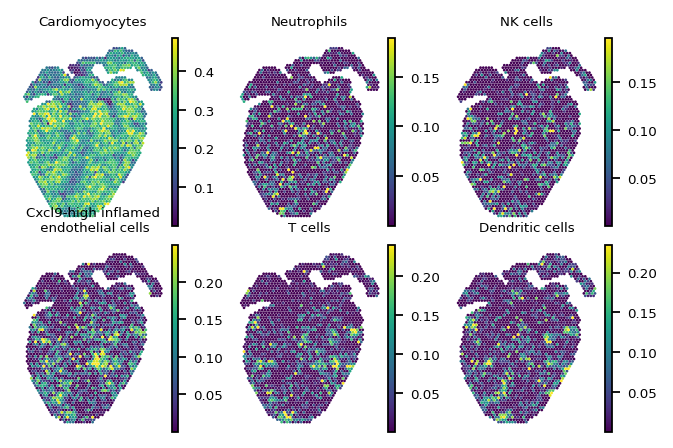

In [23]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(1.5,1.5), facecolor='white', frameon=True, transparent=True, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=["Cardiomyocytes", "Neutrophils", "NK cells", "Cxcl9-high inflamed\n endothelial cells", "T cells", "Dendritic cells"], ncols=3, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.1, wspace=0.1, save="cell_comp_interest.pdf")

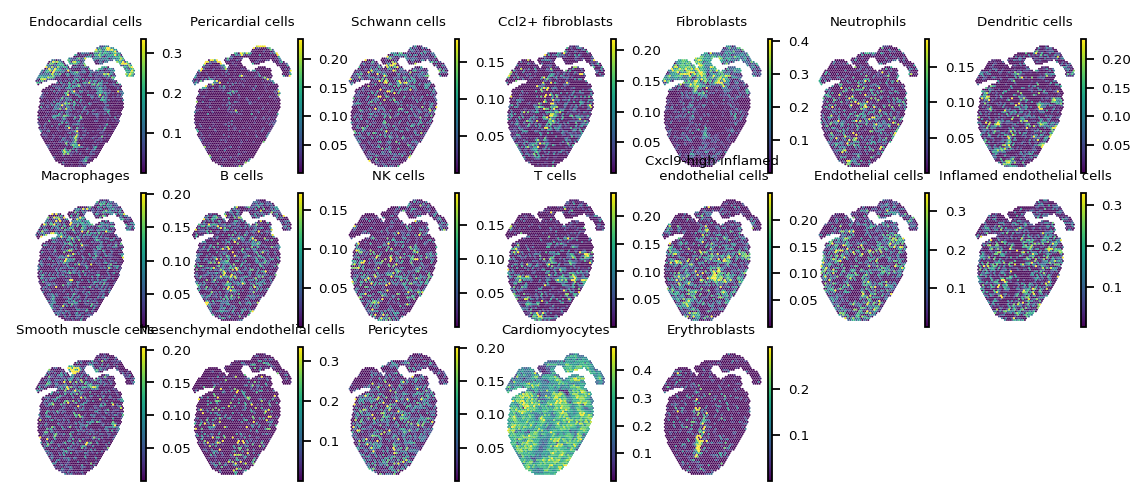

In [67]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(1.1,1.1), facecolor='white', frameon=True, transparent=True, vector_friendly = False, format="pdf")
sc.pl.spatial(T1L_heart_D7PI_visium_no_viral_genes, color=sc_cluster_order, ncols=7, frameon=False, 
              size=1.5, scale_factor=1.0, hspace=0.15, wspace=0.1, save="cell_comp.pdf")

In [33]:
T1L_heart_D7PI_visium_no_viral_genes.write_h5ad(filename="./../../../pyobjs_github/T1L_heart_D7PI_visium_no_viral_genes_composition_stereoscope_200_1500_celltypes_leiden_0.5.h5ad")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


In [34]:
T1L_heart_D7PI_visium_no_viral_genes = sc.read_h5ad(filename="./../../../pyobjs_github/T1L_heart_D7PI_visium_no_viral_genes_composition_stereoscope_200_1500_celltypes_leiden_0.5.h5ad")

In [35]:
T1L_heart_D7PI_visium_no_viral_genes.obsm["proportions"].describe()

B cells  Cardiomyocytes  Ccl2+ fibroblasts  \
count  2278.000000    2.278000e+03        2278.000000   
mean      0.029260    2.763241e-01           0.029763   
std       0.041908    9.528646e-02           0.049874   
min       0.000001    5.849361e-07           0.000001   
25%       0.000008    2.137779e-01           0.000006   
50%       0.008022    2.805682e-01           0.000045   
75%       0.047931    3.409509e-01           0.044411   
max       0.440910    5.855508e-01           0.414677   

       Cxcl9-high inflamed\n endothelial cells  Dendritic cells  \
count                              2278.000000     2.278000e+03   
mean                                  0.051669     3.619536e-02   
std                                   0.066073     5.638377e-02   
min                                   0.000001     8.234731e-07   
25%                                   0.000013     5.885176e-06   
50%                                   0.022379     9.522561e-05   
75%                                   0.088696     5.673729e-02   
max                                   0.344311     4.916682e-01   

       Endocardial cells  Endothelial cells  Erythroblasts  Fibroblasts  \
count        2278.000000        2278.000000    2278.000000  2278.000000   
mean            0.056785           0.072795       0.022955     0.078094   
std             0.079452           0.090252       0.056758     0.103167   
min             0.000001           0.000002       0.000002     0.000001   
25%             0.000007           0.000039       0.000008     0.000010   
50%             0.020123           0.034956       0.000012     0.034399   
75%             0.088462           0.125351       0.008134     0.125098   
max             0.457643           0.442406       0.561893     0.632732   

       Inflamed endothelial cells   Macrophages  \
count                 2278.000000  2.278000e+03   
mean                     0.063836  3.275821e-02   
std                      0.084982  4.418864e-02   
min                      0.000003  7.636935e-07   
25%                      0.000025  5.202372e-06   
50%                      0.018528  1.360898e-02   
75%                      0.108891  5.318816e-02   
max                      0.464789  3.305357e-01   

       Mesenchymal endothelial cells      NK cells  Neutrophils  \
count                    2278.000000  2.278000e+03  2278.000000   
mean                        0.030278  2.754387e-02     0.026389   
std                         0.072226  4.689305e-02     0.045443   
min                         0.000002  9.147285e-07     0.000001   
25%                         0.000021  4.954548e-06     0.000005   
50%                         0.000056  2.135767e-05     0.000017   
75%                         0.002665  4.355549e-02     0.042620   
max                         0.495832  3.831138e-01     0.330555   

       Pericardial cells    Pericytes  Schwann cells  Smooth muscle cells  \
count       2.278000e+03  2278.000000    2278.000000          2278.000000   
mean        1.508716e-02     0.034252       0.024929             0.027178   
std         4.317772e-02     0.047784       0.042076             0.044820   
min         5.541680e-07     0.000001       0.000001             0.000001   
25%         2.263748e-06     0.000012       0.000006             0.000009   
50%         4.259603e-06     0.007008       0.000048             0.000394   
75%         7.693765e-03     0.056271       0.038984             0.041991   
max         5.736873e-01     0.342271       0.564219             0.418224   

            T cells  
count  2.278000e+03  
mean   3.255112e-02  
std    5.544053e-02  
min    8.968186e-07  
25%    4.445605e-06  
50%    2.051464e-05  
75%    4.984742e-02  
max    4.251708e-01

In [74]:
T1L_heart_D7PI_visium_no_viral_genes.obs["regions"] = sc.read_h5ad(filename="./../../../pyobjs_github/T1L_heart_D7PI.h5ad").obs["anatomical_regions_leiden_0.8"]
ventricle_only = T1L_heart_D7PI_visium_no_viral_genes[T1L_heart_D7PI_visium_no_viral_genes.obs["regions"].isin(["Inflamed ventricle", "Myocarditic region", "Border zone"]),:]
ventricle_only.obs["regions"].cat.reorder_categories(new_categories=["Inflamed ventricle", "Border zone", "Myocarditic region"], inplace = True)

<ipython-input-74-b1f41f326fe8>:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  ventricle_only.obs["regions"].cat.reorder_categories(new_categories=["Inflamed ventricle", "Border zone", "Myocarditic region"], inplace = True)


In [76]:
import pickle
with open('./../../../pyobjs_github/anatomical_reions_colors.pickle', 'rb') as handle:
    anatomical_reions_colors = pickle.load(handle)
print(anatomical_reions_colors)
color_p = [anatomical_reions_colors[x] for x in list(ventricle_only.obs["regions"].cat.categories)]
color_p

{'Atria': '#e41a1c', 'Ventricle': '#377eb8', 'Inflamed atria': '#4daf4a', 'Inflamed ventricle': '#984ea3', 'Myocarditic region': '#ff7f00', 'Border zone': '#ffff33', 'Outflow tract': '#a65628', 'Valve': '#f781bf', 'Chamber cavity': '#999999'}


['#984ea3', '#ffff33', '#ff7f00']

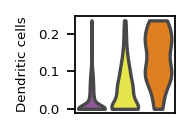

In [99]:
# ["Cardiomyocytes", "Inflamed endothelial cells", "T-cells", "Dendritic cells", "NK cells", "Cxcl9-high inflamed\n endothelial cells"]
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(0.8,0.8), transparent=True, format="pdf")
fig, ax = plt.subplots()
ax.set_axisbelow(True)
sc.pl.violin(ventricle_only, keys=["Dendritic cells"], groupby="regions", rotation=60, stripplot=False, show=False, ax = ax, palette = color_p)
plt.xticks([])
ax.set_axisbelow(True)
plt.grid(b=None)
# plt.tight_layout()
# plt.show()
plt.savefig("figures/dendritic_prop_violin.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True, metadata=None)

In [ ]:
g = sns.clustermap(celltype_corr, square=True, row_cluster=True, dendrogram_ratio=0.05, cbar_pos=(1, 0.4, .03, .4), cmap = "Blues", figsize = (10,10))
g.savefig("figures/coor_heatmap.pdf", facecolor='w', edgecolor='w',
        orientation='potrait', format="pdf",
        transparent=True)